# IMDB Movie Reviews Benchmark
The IMDB movie review benchmark is commonly used for assessing text and sentiment classification. Keras data does contain a version of it, but not the full text (just indices based on word frequency). In this notebook we'll:
* download and store the IMDB data set locally
* preprocess and use the data
* develop and assess our text classification code

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import random
import logging 
from glob import glob 
from collections import Counter

from IPython.display import SVG
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.utils import get_file
import numpy as np  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

Using TensorFlow backend.


### Add our parent path, to get to our common shared library code

In [4]:
import os
import sys
import inspect
from pathlib import Path 
currentdir = Path.cwd()
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [5]:
from mlyoucanuse.text_classification_modeler import TextClassificationModeler
from mlyoucanuse.embeddings import (load_embeddings, 
                                    create_embeddings_matrix, 
                                    get_embeddings_layer, 
                                    get_embeddings_index)

### Fix random, for reproducible tests

In [6]:
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [7]:
LOG = logging.getLogger('pos_tagger_training')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)
tf.logging.set_verbosity(tf.logging.ERROR) # silence a deprecation warning; todo revisit

### Fetch the IMDB data set and store locally

In [8]:
file_cache =os.path.join(parentdir, 'data', 'aclImdb')
if not os.path.exists(file_cache):
    os.makedirs(file_cache )

# https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
imdb_archive= 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
print(imdb_archive[:imdb_archive.rfind('/')], imdb_archive[imdb_archive.rfind('/')+1:])

origin, filename = imdb_archive[:imdb_archive.rfind('/')], imdb_archive[imdb_archive.rfind('/')+1:]
data_archive= get_file(fname=filename, origin=imdb_archive, cache_dir=file_cache, untar=False, extract=True)

https://ai.stanford.edu/~amaas/data/sentiment aclImdb_v1.tar.gz


In [9]:
imdb_files = os.path.join(parentdir , 'data/aclImdb/datasets/aclImdb')

train_pos_files = [tmp for tmp in glob(os.path.join(imdb_files, 'train', 'pos', '*.txt'))]
train_neg_files = [tmp for tmp in glob(os.path.join(imdb_files, 'train', 'neg', '*.txt'))]
test_pos_files = [tmp for tmp in glob(os.path.join(imdb_files, 'test', 'pos', '*.txt'))]
test_neg_files =  [tmp for tmp in glob(os.path.join(imdb_files, 'test', 'neg', '*.txt'))]
len(train_neg_files), len(train_pos_files), len(test_neg_files), len(test_pos_files)

(12500, 12500, 12500, 12500)

In [10]:
def read(filename):
    with open(filename, 'rt') as freader:
        return freader.read()

train_pos = [read(textfile) for textfile in train_pos_files ]   
train_neg = [read(textfile) for textfile in train_neg_files ]    
 
test_pos = [read(textfile) for textfile in test_pos_files ]   
test_neg = [read(textfile) for textfile in test_neg_files ]    


tokenizer = Tokenizer()
# The Keras tokenizer can be fit incrementally
tokenizer.fit_on_texts(train_pos)
tokenizer.fit_on_texts(train_neg)
tokenizer.fit_on_texts(test_pos)
tokenizer.fit_on_texts(test_neg)

sequences = tokenizer.texts_to_sequences(train_pos +   train_neg +  test_pos +  test_neg)

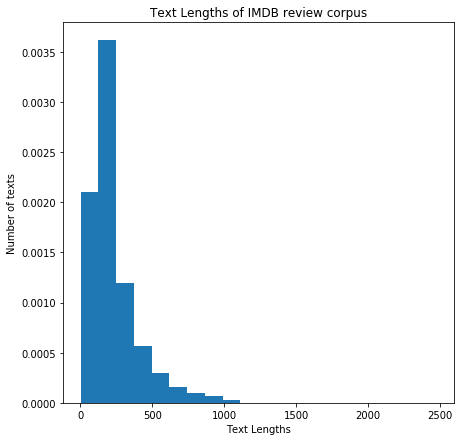

In [11]:
text_lengths = [len(tmp.split())   for tmp in train_pos +   train_neg +  test_pos +  test_neg]

top_label, side_label, bottom_label = ( 'Text Lengths', 'Number of texts',
                                       'Text Lengths of IMDB review corpus')
fig = plt.figure(figsize=(7,7))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
n, bins, patches = plt.hist(text_lengths, bins=20, density=True)
plt.show()

In [12]:
MAX_SEQUENCE_LEN = 2500

In [13]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LEN)

y= np.array([1] * len(train_pos_files) 
           + [0] * len (train_neg_files)
           + [1] * len(test_pos_files)
           + [0] * len(test_neg_files))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
X_test , X_validation , y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

In [15]:
EMBEDDING_SIZE = 50 # 300

In [16]:
embed_index = get_embeddings_index( 'glove', parentdir=parentdir, embedding_dimensions = EMBEDDING_SIZE)

INFO:mlyoucanuse.embeddings:Downloading, please wait.
INFO:mlyoucanuse.embeddings:Done downloading
INFO:mlyoucanuse.embeddings:Found 400000 word vectors.


In [17]:
print(f'Vocabulary size: {len(tokenizer.word_index):,}')
embeddings_matrix = create_embeddings_matrix(embed_index, 
                                            vocabulary=tokenizer.index_word,
                                            embedding_dim=EMBEDDING_SIZE)

Vocabulary size: 124,252


INFO:mlyoucanuse.embeddings:Embeddings matrix shape: (124253, 50)


In [18]:
embeddings_layer= get_embeddings_layer(embeddings_matrix,
                                       'embedding_static',
                                        max_len=MAX_SEQUENCE_LEN,
                                        trainable=False)

In [19]:
text_cls = TextClassificationModeler(max_sequence_len=MAX_SEQUENCE_LEN)
model = text_cls.build_model(embeddings_layer)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2500)         0                                            
__________________________________________________________________________________________________
embedding_static (Embedding)    (None, 2500, 50)     6212650     main_input[0][0]                 
__________________________________________________________________________________________________
Conv_static_2 (Conv1D)          (None, 2499, 100)    10100       embedding_static[0][0]           
__________________________________________________________________________________________________
Conv_static_3 (Conv1D)          (None, 2498, 100)    15100       embedding_static[0][0]           
__________________________________________________________________________________________________
Conv_stati

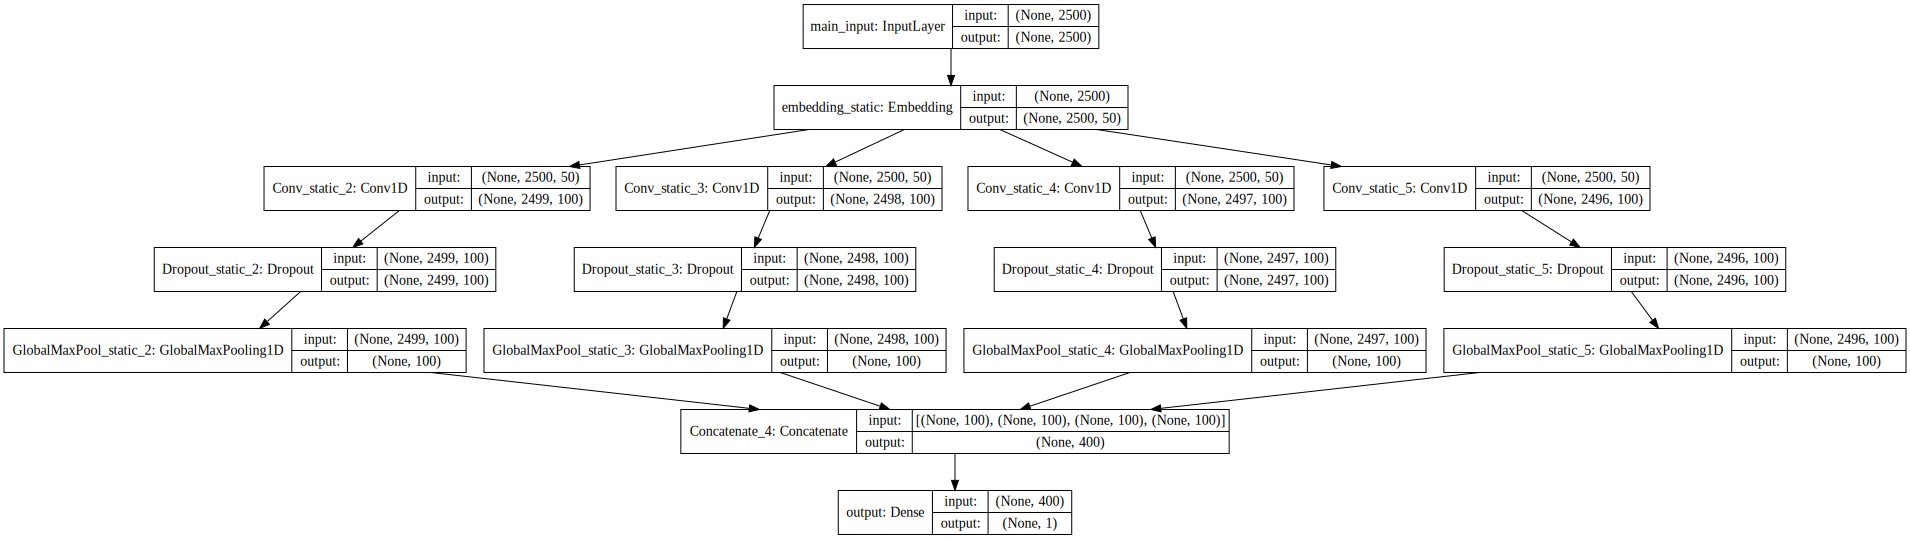

In [47]:
SVG(model_to_dot(model,
                 show_layer_names=True,
                 show_shapes=True).create(prog='dot',
                                          format='svg'))

In [48]:
history = model.fit(X_train, y_train,
                               validation_data=(X_validation, y_validation),
                               epochs=6,
                               batch_size=64)

Train on 40000 samples, validate on 5000 samples
Epoch 1/6
40000/40000 [==============================] - 1855s 46ms/step - loss: 0.6640 - acc: 0.5903 - val_loss: 0.6143 - val_acc: 0.7464
Epoch 2/6
40000/40000 [==============================] - 1839s 46ms/step - loss: 0.5607 - acc: 0.7138 - val_loss: 0.5406 - val_acc: 0.7662
Epoch 3/6
40000/40000 [==============================] - 1841s 46ms/step - loss: 0.5007 - acc: 0.7560 - val_loss: 0.5005 - val_acc: 0.7782
Epoch 4/6
40000/40000 [==============================] - 1835s 46ms/step - loss: 0.4553 - acc: 0.7865 - val_loss: 0.4649 - val_acc: 0.8028
Epoch 5/6
40000/40000 [==============================] - 1835s 46ms/step - loss: 0.4335 - acc: 0.7986 - val_loss: 0.4445 - val_acc: 0.8160
Epoch 6/6
40000/40000 [==============================] - 1831s 46ms/step - loss: 0.4060 - acc: 0.8142 - val_loss: 0.4306 - val_acc: 0.8246


In [49]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend() 

Accuracy: 81.38


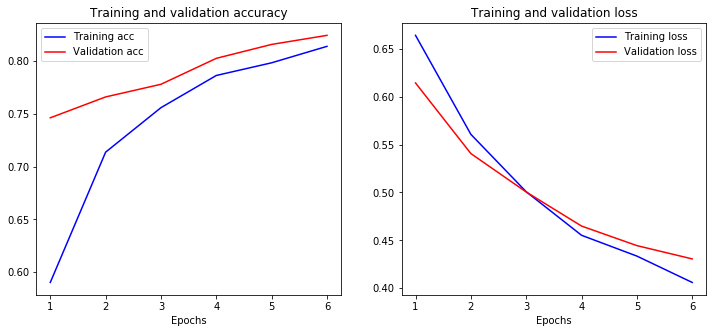

In [51]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100:.2f}')
plot_history(history)